In [164]:
# import all libraries you need here
import pandas as pd
import numpy as np
import pathlib as pl

import scanpy as sc
import seaborn as sns

# Clustering: Downloading

In [165]:
path_data = pl.Path("./data")

In [ ]:


train_adata = sc.read_h5ad(path_data / "train_adata.h5ad")
test_adata = sc.read_h5ad(path_data / "test_adata.h5ad")

all_bulkified = pd.read_csv(path_data / "bulkified_data.csv",index_col=0)
train_bulk = pd.read_csv(path_data / "train_bulk.csv",index_col=0)
train_bulk_true_props = pd.read_csv(path_data / "train_bulk_trueprops.csv",index_col=0)

In [167]:
train_adata

AnnData object with n_obs × n_vars = 32374 × 7725
    obs: 'Sample', 'Patient', 'Tumor status', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'highLevelType', 'chemo'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [168]:
test_adata.obs['highLevelType'] = None

In [169]:
test_adata

AnnData object with n_obs × n_vars = 18616 × 7725
    obs: 'Sample', 'Patient', 'Tumor status', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'chemo', 'highLevelType'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [ ]:
merged_adata = train_adata.concatenate(
    test_adata, 
    batch_key='dataset', 
    batch_categories=['train', 'test'],
    uns_merge='unique'
)

In [171]:
merged_adata

AnnData object with n_obs × n_vars = 50990 × 7725
    obs: 'Sample', 'Patient', 'Tumor status', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'highLevelType', 'chemo', 'dataset'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [172]:
# val_adata = merged_adata[merged_adata.obs['Sample'] == 's8'].copy()

# Filter out 's8' sample from the original dataset to create training dataset
# train_adata = merged_adata[merged_adata.obs['Sample'] != 's8'].copy()
# train_adata = merged_adata[merged_adata.obs['Sample'] != 's3'].copy()

In [173]:
print(f"Number of patients to deconvolve: {all_bulkified.shape[1]}")
print(f"Number of genes in dataset: {all_bulkified.shape[0]}")

Number of patients to deconvolve: 20
Number of genes in dataset: 7725


In [174]:
print(f"Number of cells in the train set {train_adata.n_obs}")
for spl in train_adata.obs.Sample.unique():
    print(f"Number of cells for {spl} is {train_adata[train_adata.obs.Sample==spl].n_obs}")

Number of cells in the train set 32374
Number of cells for s1 is 6821
Number of cells for s2 is 4555
Number of cells for s3 is 5166
Number of cells for s4 is 5607
Number of cells for s7 is 4471
Number of cells for s8 is 5754


In [175]:
print(f"There are {train_adata.obs.highLevelType.nunique()} different cell types in the dataset")
print(f"The different cells types are {train_adata.obs.highLevelType.unique().astype(str)}")

There are 9 different cell types in the dataset
The different cells types are ['T' 'B' 'Plasmablast' 'Fibroblast' 'Mast' 'Myeloid' 'NK' 'Myofibroblast'
 'Endothelial']


In [176]:
print(f"Number of cells in the test set {test_adata.n_obs}")
for spl in test_adata.obs.Sample.unique():
    print(f"Number of cells for {spl} is {test_adata[test_adata.obs.Sample==spl].n_obs}")

Number of cells in the test set 18616
Number of cells for s5 is 6020
Number of cells for s6 is 5530
Number of cells for s9 is 3336
Number of cells for s10 is 3730


# Clustering: Preprocessing

This and the next section (preprocessing and predicting) are mainly inspired by the scanpy documentation, particularly: https://scanpy.readthedocs.io/en/stable/tutorials/basics/clustering.html

## Visualization

In [177]:
merged_adata

AnnData object with n_obs × n_vars = 50990 × 7725
    obs: 'Sample', 'Patient', 'Tumor status', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'highLevelType', 'chemo', 'dataset'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

['Tumor', 'AN']
Categories (2, object): ['AN', 'Tumor']


<Axes: xlabel='Tumor status', ylabel='Count'>

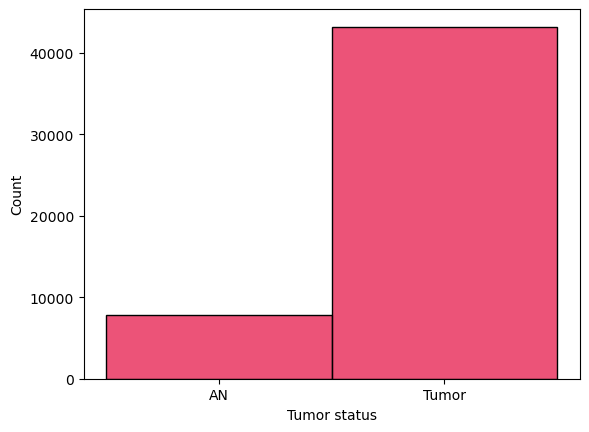

In [178]:
print(merged_adata.obs["Tumor status"].unique())
sns.histplot(merged_adata.obs["Tumor status"])

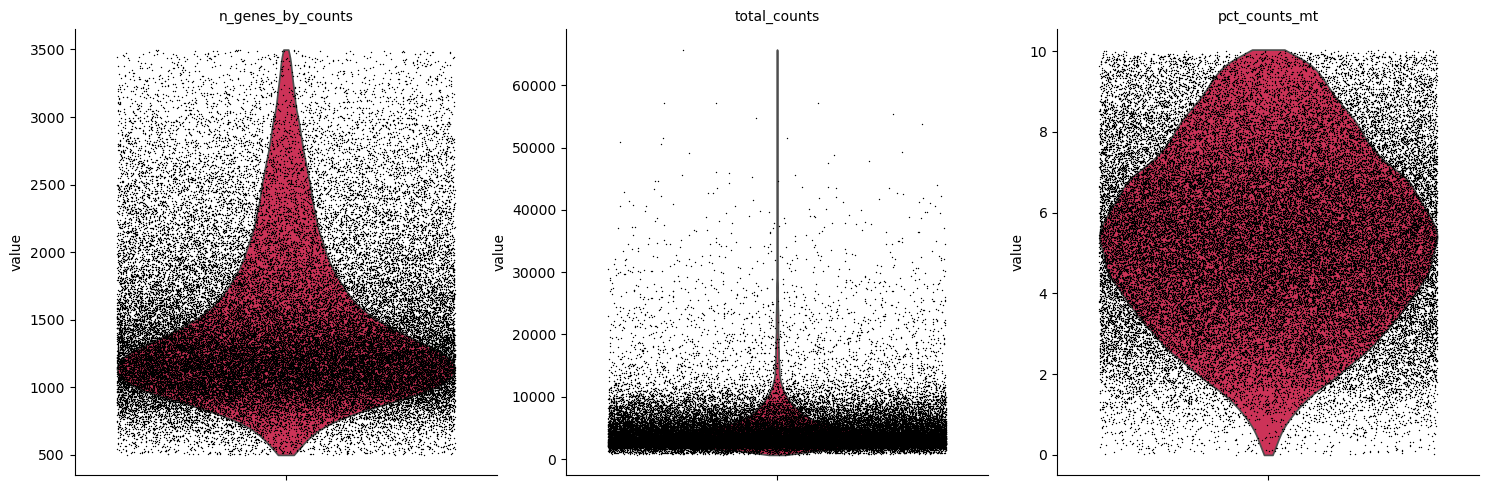

In [179]:
sc.pl.violin(merged_adata, ["n_genes_by_counts", "total_counts", "pct_counts_mt"], jitter=0.4, multi_panel=True)

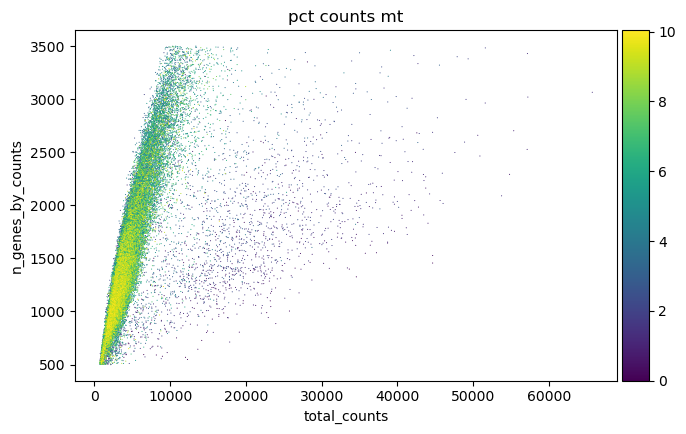

In [180]:
sc.pl.scatter(merged_adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

## Imputation

Nothing to be done here

In [181]:
# sc.external.pp.dca(train_adata)

## Filtering

In [182]:
sc.pp.filter_cells(merged_adata, min_genes=100)
sc.pp.filter_genes(merged_adata, min_cells=50)

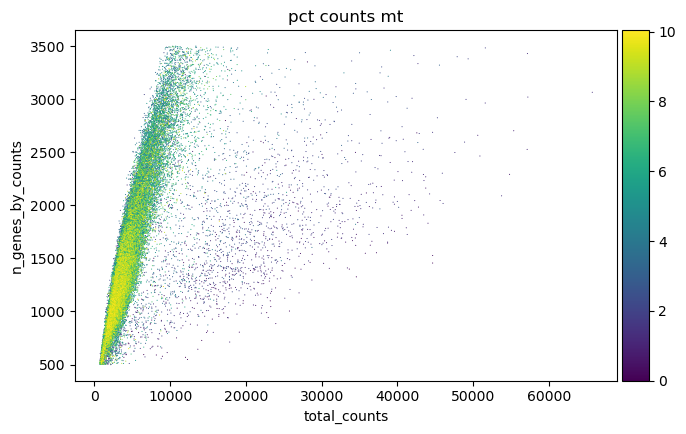

In [183]:
sc.pl.scatter(merged_adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

## Doublet

Nothing done here

In [184]:
# sc.external.pp.scrublet(train_adata, batch_key="Sample")

## Normalization

In [185]:
sc.pp.normalize_total(merged_adata)
sc.pp.log1p(merged_adata)

## Highly Variable Genes

In [186]:
sc.pp.highly_variable_genes(merged_adata, n_top_genes=400, batch_key="Sample")

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


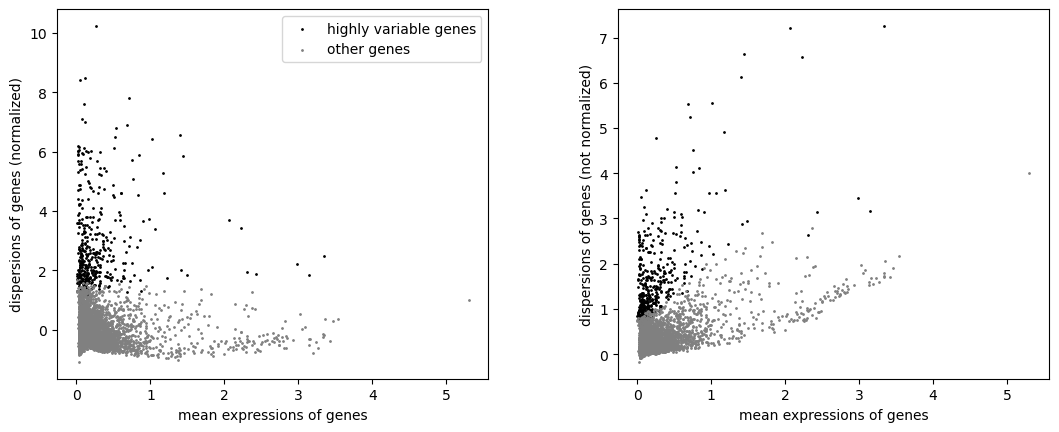

In [187]:
sc.pl.highly_variable_genes(merged_adata)

## Batch correction

In [188]:
sc.pp.combat(merged_adata, key='Sample')

## PCA

In [189]:
sc.tl.pca(merged_adata)

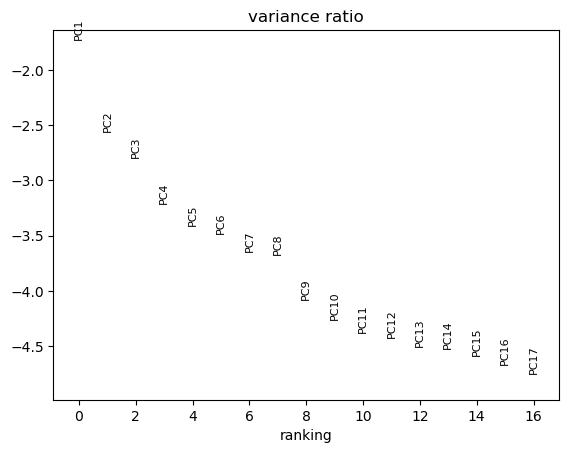

In [190]:
sc.pl.pca_variance_ratio(merged_adata, n_pcs=16, log=True)

## Neighbors

In [191]:
sc.pp.neighbors(merged_adata)

## UMAP

In [192]:
sc.tl.umap(merged_adata)

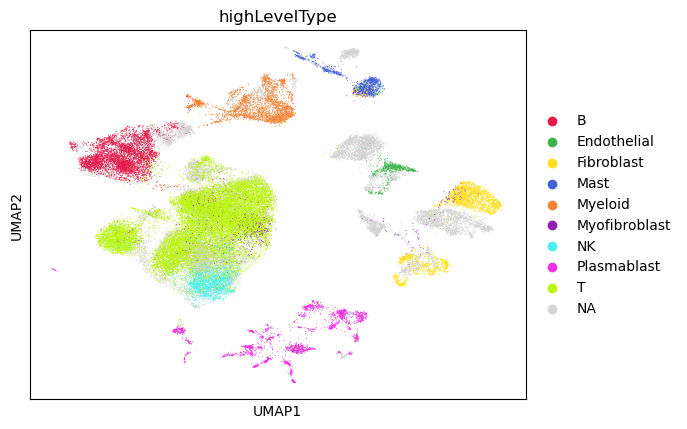

In [193]:
sc.pl.umap(
    merged_adata,
    color="highLevelType",
    # Setting a smaller point size to get prevent overlap
    size=2,
)

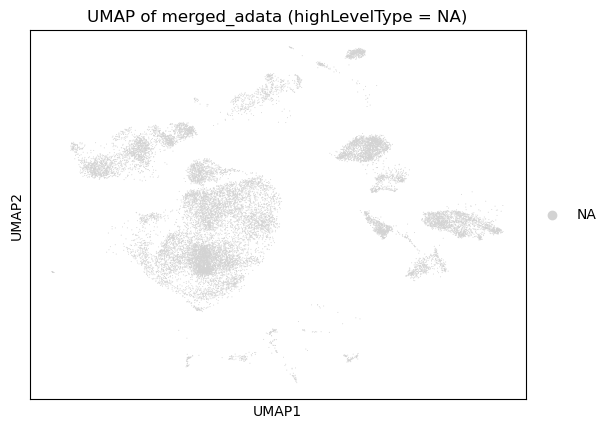

In [194]:
na_subset = merged_adata[merged_adata.obs['highLevelType'].isna()]

# Plot for NA subset
sc.pl.umap(
    na_subset,
    color="highLevelType",  # This will be empty since all are NA
    size=2,
    title="UMAP of merged_adata (highLevelType = NA)"
)

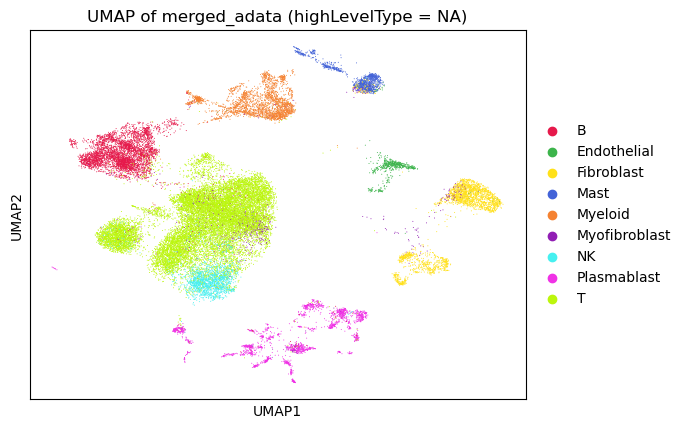

In [195]:
na_subset = merged_adata[~merged_adata.obs['highLevelType'].isna()]

# Plot for NA subset
sc.pl.umap(
    na_subset,
    color="highLevelType",  # This will be empty since all are NA
    size=2,
    title="UMAP of merged_adata (highLevelType = NA)"
)

# Clustering: Prediction

## Helper Functions

In [196]:
from sklearn.neighbors import KNeighborsClassifier

def classifyNearestNeighbors(X_labeled, y, X_unlabeled, n_neighbors):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_labeled, y)

    predicted_labels = knn.predict(X_unlabeled)

    return predicted_labels

In [197]:
from sklearn.metrics import adjusted_rand_score, v_measure_score

def evaluate_predictions(y_true, y_pred):
    ari = adjusted_rand_score(y_true, y_pred)
    v_measure = v_measure_score(y_true, y_pred)
    
    combined_score = 0.5 * ari + 0.5 * v_measure
    
    return combined_score

## Validation

In [198]:
train_adata = merged_adata[(~merged_adata.obs['highLevelType'].isna()) & (merged_adata.obs['Sample'] != 's8')]
X_train = train_adata.obsm["X_umap"]
y_train = train_adata.obs["highLevelType"]

In [199]:
val_adata = merged_adata[merged_adata.obs['Sample'] == 's8']
X_val = val_adata.obsm["X_umap"]
y_val = val_adata.obs["highLevelType"]

In [200]:
y_hat = classifyNearestNeighbors(X_train, y_train, X_val, n_neighbors=100)
evaluate_predictions(y_val, y_hat)

0.8853686787114309

## Test

In [201]:
train_adata = merged_adata[~merged_adata.obs['highLevelType'].isna()]
X_train = train_adata.obsm["X_umap"]
y_train = train_adata.obs["highLevelType"]

In [202]:
test_adata = merged_adata[merged_adata.obs['highLevelType'].isna()]
X_test = test_adata.obsm["X_umap"]

In [203]:
y_hat = classifyNearestNeighbors(X_train, y_train, X_test, n_neighbors=50)

In [204]:
joint_adata = merged_adata.copy()
joint_adata.obs.loc[joint_adata.obs['highLevelType'].isna(), 'highLevelType'] = y_hat

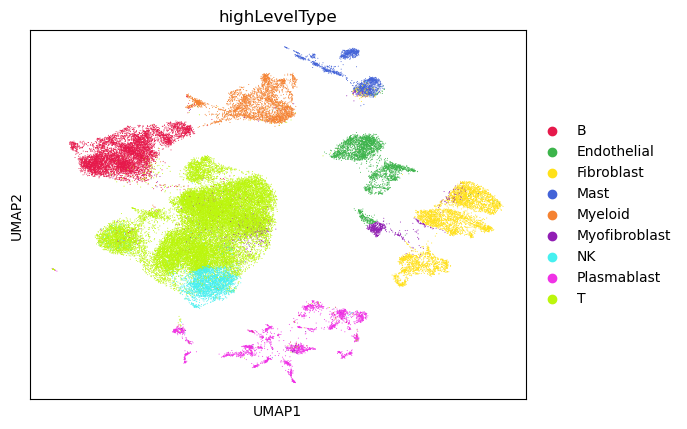

In [205]:
sc.pl.umap(
    joint_adata,
    color="highLevelType",
    size=2,
)

In [206]:
test_adata_copy = test_adata.copy()

In [207]:
test_adata_copy.obs['highLevelType'] = y_hat

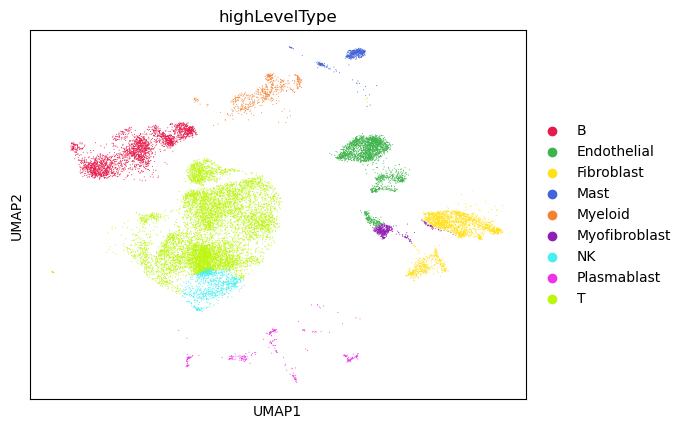

In [208]:
sc.pl.umap(
    test_adata_copy,
    color="highLevelType",
    size=2,
)

In [209]:
cluster_labels = y_hat

# Deconvolution: Downloading

## Helper

In [219]:
def average_rmse(df1, df2):
    assert df1.shape == df2.shape
    
    rmse_per_column = np.sqrt(((df1 - df2) ** 2).mean(axis=0))
    
    avg_rmse = rmse_per_column.mean()
    
    return avg_rmse

## Download

In [220]:
path_data = pl.Path("./data")

In [221]:
train_adata = sc.read_h5ad(path_data / "train_adata.h5ad")
test_adata = sc.read_h5ad(path_data / "test_adata.h5ad")

all_bulkified = pd.read_csv(path_data / "bulkified_data.csv",index_col=0)
train_bulk = pd.read_csv(path_data / "train_bulk.csv",index_col=0)
train_bulk_true_props = pd.read_csv(path_data / "train_bulk_trueprops.csv",index_col=0)

In [222]:
merged_adata = train_adata.concatenate(
    test_adata, 
    batch_key='dataset', 
    batch_categories=['train', 'test'],
    uns_merge='unique'
)

In [223]:
all_bulkified

,s5_0,s5_1,s5_2,s5_3,s5_4,s6_0,s6_1,s6_2,s6_3,s6_4,s9_0,s9_1,s9_2,s9_3,s9_4,s10_0,s10_1,s10_2,s10_3,s10_4
Unnamed: 0,,,,,,,,,,,,,,,,,,,,
NOC2L,270.0,270.0,293.0,261.0,230.0,152.0,150.0,143.0,187.0,146.0,87.0,68.0,81.0,71.0,69.0,115.0,127.0,112.0,121.0,109.0
HES4,174.0,165.0,186.0,218.0,166.0,162.0,145.0,234.0,180.0,183.0,298.0,198.0,246.0,235.0,301.0,367.0,520.0,284.0,445.0,308.0
ISG15,2318.0,2028.0,2616.0,2343.0,1854.0,387.0,451.0,479.0,408.0,469.0,492.0,446.0,431.0,437.0,515.0,456.0,497.0,557.0,478.0,570.0
TNFRSF18,1179.0,1044.0,1413.0,1025.0,953.0,174.0,201.0,222.0,198.0,201.0,105.0,121.0,119.0,93.0,125.0,166.0,149.0,168.0,156.0,174.0
TNFRSF4,756.0,484.0,744.0,462.0,441.0,197.0,174.0,143.0,240.0,165.0,74.0,93.0,95.0,87.0,97.0,158.0,168.0,187.0,140.0,230.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MT-ND6,974.0,961.0,1062.0,1026.0,869.0,408.0,422.0,424.0,431.0,420.0,442.0,501.0,487.0,486.0,458.0,455.0,457.0,490.0,439.0,452.0
MT-CYB,35428.0,34043.0,34742.0,34986.0,32324.0,22091.0,22431.0,25607.0,24129.0,22050.0,16008.0,15329.0,15838.0,16886.0,16471.0,17339.0,18553.0,16105.0,16779.0,14956.0
SELE,253.0,252.0,253.0,252.0,252.0,94.0,32.0,67.0,89.0,52.0,235.0,1011.0,522.0,1005.0,547.0,742.0,986.0,1197.0,876.0,748.0


In [224]:
train_bulk.T

Unnamed: 0,NOC2L,HES4,ISG15,TNFRSF18,TNFRSF4,SDF4,B3GALT6,UBE2J2,INTS11,MXRA8,...,MT-CO3,MT-ND3,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-CYB,SELE,SOX17,CCL14
s1_0,201.0,470.0,852.0,712.0,550.0,349.0,75.0,173.0,133.0,153.0,...,24905.0,20032.0,1410.0,22778.0,6265.0,388.0,19633.0,0.0,0.0,0.0
s1_1,226.0,532.0,918.0,870.0,472.0,477.0,89.0,226.0,185.0,205.0,...,28573.0,26806.0,1687.0,27391.0,8138.0,449.0,23647.0,0.0,0.0,0.0
s2_0,133.0,874.0,1995.0,1753.0,920.0,362.0,77.0,176.0,188.0,14.0,...,9041.0,12314.0,2033.0,11565.0,3708.0,198.0,11206.0,0.0,0.0,0.0
s2_1,150.0,924.0,2116.0,1925.0,1207.0,398.0,91.0,154.0,169.0,22.0,...,9788.0,12685.0,2234.0,12550.0,4309.0,215.0,12172.0,0.0,0.0,0.0
s3_0,167.0,332.0,1221.0,352.0,211.0,374.0,83.0,143.0,185.0,271.0,...,41071.0,33978.0,1047.0,26502.0,6181.0,433.0,33159.0,0.0,0.0,0.0
s3_1,176.0,352.0,1282.0,289.0,240.0,392.0,84.0,165.0,193.0,493.0,...,41458.0,33136.0,1032.0,26677.0,6291.0,389.0,34322.0,0.0,0.0,0.0
s4_0,235.0,661.0,1649.0,2069.0,940.0,531.0,130.0,165.0,188.0,221.0,...,45721.0,41965.0,1556.0,28363.0,7676.0,781.0,35769.0,6.0,1.0,0.0
s4_1,190.0,463.0,1152.0,1357.0,943.0,452.0,123.0,155.0,187.0,218.0,...,37713.0,33823.0,1256.0,23695.0,6282.0,610.0,28999.0,6.0,1.0,0.0
s7_0,147.0,432.0,957.0,446.0,310.0,358.0,72.0,105.0,110.0,138.0,...,49712.0,55956.0,2426.0,30166.0,6703.0,500.0,36451.0,511.0,31.0,75.0
s7_1,123.0,349.0,847.0,367.0,278.0,345.0,60.0,98.0,92.0,60.0,...,50413.0,56821.0,2660.0,29924.0,6496.0,524.0,35301.0,957.0,100.0,145.0


In [225]:
train_bulk_true_props.T

highLevelType,T,Fibroblast,NK,Myeloid,Mast,B,Myofibroblast,Endothelial,Plasmablast
s1_0,0.568586,0.105188,0.073205,0.064677,0.059701,0.049751,0.041222,0.024165,0.013504
s1_1,0.359160,0.130663,0.136573,0.021011,0.038083,0.079448,0.038083,0.022324,0.174655
s2_0,0.489681,0.065666,0.117261,0.030019,0.146341,0.089118,0.030019,0.030019,0.001876
s2_1,0.570671,0.038869,0.055654,0.079505,0.005300,0.075088,0.093640,0.028269,0.053004
s3_0,0.458667,0.048000,0.168889,0.064000,0.040889,0.040000,0.061333,0.009778,0.108444
s3_1,0.657534,0.095085,0.058018,0.029009,0.019339,0.052377,0.075745,0.008864,0.004029
s4_0,0.340176,0.079912,0.320381,0.081378,0.009531,0.074780,0.075513,0.017595,0.000733
s4_1,0.395770,0.109768,0.129909,0.135952,0.041289,0.046324,0.084592,0.024169,0.032226
s7_0,0.583417,0.097902,0.126873,0.007992,0.017982,0.029970,0.011988,0.049950,0.073926
s7_1,0.519878,0.045872,0.014271,0.051988,0.018349,0.171254,0.012232,0.084608,0.081549


# Deconvolution: Computing the Signature Matrix

In [226]:
grouped_data = sc.get.aggregate(train_adata, by="highLevelType", func="mean")

In [227]:
signature = pd.DataFrame(grouped_data.layers["mean"].T, columns=list(grouped_data.obs["highLevelType"]))

In [228]:
signature.insert(0, "gene_name", list(all_bulkified.index))

In [229]:
signature = signature.set_index("gene_name")

Include batch correction maybe

# Deconvolution: Validation

Here I use the following Deconvolution Package: https://github.com/LiBuchauer/cellanneal

In [230]:
import cellanneal

In [249]:
gene_dict = cellanneal.make_gene_dictionary(
                    signature,
                    train_bulk,
                    disp_min=0.5,
                    bulk_min=1e-5,
                    bulk_max=0.01)

2106 highly variable genes identified in cell type
        reference.
	1864 of these are within thresholds for sample s1_0
	1739 of these are within thresholds for sample s1_1
	1535 of these are within thresholds for sample s2_0
	1584 of these are within thresholds for sample s2_1
	1831 of these are within thresholds for sample s3_0
	1881 of these are within thresholds for sample s3_1
	1819 of these are within thresholds for sample s4_0
	1847 of these are within thresholds for sample s4_1
	1898 of these are within thresholds for sample s7_0
	1893 of these are within thresholds for sample s7_1
	1841 of these are within thresholds for sample s8_0
	1888 of these are within thresholds for sample s8_1


In [250]:
all_mix_df = cellanneal.deconvolve(
                signature,
                train_bulk,
                maxiter=1000,
                gene_dict=gene_dict)

Deconvolving sample 1 of 12 (s1_0) ...
Deconvolving sample 2 of 12 (s1_1) ...
Deconvolving sample 3 of 12 (s2_0) ...
Deconvolving sample 4 of 12 (s2_1) ...
Deconvolving sample 5 of 12 (s3_0) ...
Deconvolving sample 6 of 12 (s3_1) ...
Deconvolving sample 7 of 12 (s4_0) ...
Deconvolving sample 8 of 12 (s4_1) ...
Deconvolving sample 9 of 12 (s7_0) ...
Deconvolving sample 10 of 12 (s7_1) ...
Deconvolving sample 11 of 12 (s8_0) ...
Deconvolving sample 12 of 12 (s8_1) ...


In [251]:
cleaned_predictions = all_mix_df.T.drop(index=["rho_Spearman", "rho_Pearson"])
sorted_predictions = cleaned_predictions.reindex(index=['T', 'Fibroblast', 'NK', 'Myeloid', 'Mast', 'B', 'Myofibroblast', 'Endothelial', 'Plasmablast']
)


In [234]:
average_rmse(sorted_predictions, train_bulk_true_props)

0.05314292638409717

# Deconvolution: Predicting Test Set

In [254]:
gene_dict = cellanneal.make_gene_dictionary(
                    signature,
                    all_bulkified,
                    disp_min=0.5,
                    bulk_min=1e-5,
                    bulk_max=0.01)

2106 highly variable genes identified in cell type
        reference.
	1966 of these are within thresholds for sample s10_0
	2006 of these are within thresholds for sample s10_1
	1911 of these are within thresholds for sample s10_2
	2028 of these are within thresholds for sample s10_3
	1897 of these are within thresholds for sample s10_4
	1901 of these are within thresholds for sample s5_0
	1844 of these are within thresholds for sample s5_1
	1832 of these are within thresholds for sample s5_2
	1908 of these are within thresholds for sample s5_3
	1944 of these are within thresholds for sample s5_4
	1969 of these are within thresholds for sample s6_0
	1931 of these are within thresholds for sample s6_1
	2029 of these are within thresholds for sample s6_2
	2011 of these are within thresholds for sample s6_3
	1973 of these are within thresholds for sample s6_4
	1941 of these are within thresholds for sample s9_0
	1842 of these are within thresholds for sample s9_1
	1961 of these are withi

In [255]:
all_mix_df = cellanneal.deconvolve(
                signature,
                all_bulkified,
                maxiter=1000,
                gene_dict=gene_dict)

Deconvolving sample 1 of 20 (s10_0) ...
Deconvolving sample 2 of 20 (s10_1) ...
Deconvolving sample 3 of 20 (s10_2) ...
Deconvolving sample 4 of 20 (s10_3) ...
Deconvolving sample 5 of 20 (s10_4) ...
Deconvolving sample 6 of 20 (s5_0) ...
Deconvolving sample 7 of 20 (s5_1) ...
Deconvolving sample 8 of 20 (s5_2) ...
Deconvolving sample 9 of 20 (s5_3) ...
Deconvolving sample 10 of 20 (s5_4) ...
Deconvolving sample 11 of 20 (s6_0) ...
Deconvolving sample 12 of 20 (s6_1) ...
Deconvolving sample 13 of 20 (s6_2) ...
Deconvolving sample 14 of 20 (s6_3) ...
Deconvolving sample 15 of 20 (s6_4) ...
Deconvolving sample 16 of 20 (s9_0) ...
Deconvolving sample 17 of 20 (s9_1) ...
Deconvolving sample 18 of 20 (s9_2) ...
Deconvolving sample 19 of 20 (s9_3) ...
Deconvolving sample 20 of 20 (s9_4) ...


In [282]:
cleaned_predictions = all_mix_df.T.drop(index=["rho_Spearman", "rho_Pearson"])
sorted_predictions = cleaned_predictions.reindex(index=['T', 'Endothelial', 'Fibroblast', 'Plasmablast', 'B', 'Myofibroblast',
       'NK', 'Myeloid', 'Mast'])

In [283]:
correct_order = ['s5_0', 's5_1', 's5_2', 's5_3', 's5_4', 
                 's6_0', 's6_1', 's6_2', 's6_3', 's6_4', 
                 's9_0', 's9_1', 's9_2', 's9_3', 's9_4', 
                 's10_0', 's10_1', 's10_2', 's10_3', 's10_4']

In [284]:
sorted_predictions = sorted_predictions[correct_order]

In [285]:
sorted_predictions = sorted_predictions.reset_index()

In [286]:
sorted_predictions

,index,s5_0,s5_1,s5_2,s5_3,s5_4,s6_0,s6_1,s6_2,s6_3,...,s9_0,s9_1,s9_2,s9_3,s9_4,s10_0,s10_1,s10_2,s10_3,s10_4
0,T,0.545331,5.748410e-01,0.523629,0.517639,0.442830,0.451914,0.577404,0.281419,0.540402,...,0.244692,0.368389,0.285092,0.341289,0.247338,0.217927,0.253252,0.403257,0.160203,0.546553
1,Endothelial,0.087120,8.691931e-02,0.078562,0.089864,0.100095,0.137095,0.100566,0.104373,0.134195,...,0.116681,0.244550,0.176652,0.311367,0.119320,0.120543,0.169808,0.188741,0.142161,0.128200
2,Fibroblast,0.025069,3.022628e-02,0.001481,0.029314,0.034528,0.036791,0.129810,0.104909,0.074346,...,0.113924,0.033374,0.094034,0.085915,0.157103,0.118182,0.094423,0.050998,0.097806,0.048582
3,Plasmablast,0.036178,7.787878e-03,0.015812,0.014814,0.011420,0.000000,0.006630,0.008827,0.001974,...,0.000717,0.000039,0.003411,0.009885,0.012472,0.008038,0.011057,0.016546,0.026392,0.005340
4,B,0.050387,1.332322e-01,0.082558,0.091043,0.164036,0.056353,0.054454,0.075812,0.083314,...,0.208315,0.094399,0.122699,0.102689,0.093463,0.196676,0.084576,0.057387,0.153461,0.101735
5,Myofibroblast,0.034495,8.504146e-05,0.018808,0.019229,0.005154,0.193391,0.018774,0.156996,0.053278,...,0.231437,0.190644,0.161412,0.122040,0.221052,0.213978,0.257428,0.129005,0.159074,0.158392
6,NK,0.196099,1.622461e-01,0.234799,0.224527,0.208646,0.092668,0.112231,0.190256,0.057341,...,0.050638,0.068540,0.088916,0.026759,0.149038,0.108529,0.047319,0.130959,0.151047,0.006846
7,Myeloid,0.025245,4.661683e-03,0.044338,0.011986,0.033240,0.010028,0.000102,0.074212,0.029530,...,0.033490,0.000004,0.067722,0.000046,0.000209,0.003628,0.080914,0.023102,0.090682,0.004168
8,Mast,0.000077,5.057557e-07,0.000014,0.001583,0.000050,0.021761,0.000029,0.003195,0.025620,...,0.000105,0.000060,0.000063,0.000011,0.000005,0.012498,0.001222,0.000005,0.019174,0.000184


# Exporting

In [310]:
results_path = pl.Path("./exports/")

In [277]:
np.append(["index"],all_bulkified.columns)

array(['index', 's5_0', 's5_1', 's5_2', 's5_3', 's5_4', 's6_0', 's6_1',
       's6_2', 's6_3', 's6_4', 's9_0', 's9_1', 's9_2', 's9_3', 's9_4',
       's10_0', 's10_1', 's10_2', 's10_3', 's10_4'], dtype=object)

In [278]:
sorted_predictions.columns

Index(['index', 's5_0', 's5_1', 's5_2', 's5_3', 's5_4', 's6_0', 's6_1', 's6_2',
       's6_3', 's6_4', 's9_0', 's9_1', 's9_2', 's9_3', 's9_4', 's10_0',
       's10_1', 's10_2', 's10_3', 's10_4'],
      dtype='object')

In [279]:
assert all(sorted_predictions.columns == np.append(["index"],all_bulkified.columns)), "Wrong columns"

In [288]:
assert all(sorted_predictions['index']== ['T', 'Endothelial', 'Fibroblast', 'Plasmablast', 'B', 'Myofibroblast',
       'NK', 'Myeloid', 'Mast']), "Wrong order for cell types"

In [289]:
assert all(sorted_predictions.drop("index",axis=1).sum().round()==1), "The proportions for a single patient must sum to 1"

In [297]:
indices = [i+1 for i in range(len(test_adata.obs))]

In [306]:
# cluster_labels should be a DataFrame containing the cluster labels for each cell
data = {
    'index': test_adata.obs_names,
    'cluster': cluster_labels
}
clusters = pd.DataFrame(data, columns=["index", "cluster"])

In [307]:
assert all(clusters.columns == ["index", "cluster"]), "Wrong columns"

In [308]:
assert all(clusters["index"] == test_adata.obs_names), "The cell ids are either not all present or not in the right order"

In [313]:
import zipfile

archive_name = "Sigl_Simon_Britz_Niklas_Project2.zip" # TODO

with zipfile.ZipFile(results_path / archive_name, "x") as zf:
    with zf.open(f"pred_props.csv", "w") as buffer:
        sorted_predictions.to_csv(buffer)
    with zf.open(f"cluster_membership.csv", "w") as buffer:
        clusters.to_csv(buffer)
    zf.close()